<a href="https://colab.research.google.com/github/09-ig/09-ig/blob/main/weaning_synthetic_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [ ]:
def generate_extubation_dataset(n_patients=500, avg_duration_hours=72):

    np.random.seed(42)

    patients = []

    for patient_id in range(n_patients):
        # Patient characteristics
        age = np.random.normal(65, 15)
        age = max(18, min(90, age))  #This is age range between 18-90

        # APACHE II score (higher = sicker)
        #It predicts the mortality based on the ICU values
        apache_ii = np.random.normal(15, 5)
        apache_ii = max(0, min(35, apache_ii))

        # Factor of comorbidity
        #(Where all the individual factors impact the overall health)
        comorbidity_severity = np.random.exponential(0.3)

        # Duration of mechanical ventilation (hours)
        duration = np.random.exponential(avg_duration_hours / 2) + 24
        duration = min(duration, 720)  # Max 30 days

        # Generate time series data (every 3 minutes = 20 readings per hour)
        n_readings = int(duration * 20)
        timestamps = [datetime.now() + timedelta(minutes=3*i) for i in range(n_readings)]

        # Base ventilator settings influenced by patient characteristics
        base_fio2 = 0.3 + 0.3 * (apache_ii / 35) + 0.1 * comorbidity_severity
        base_fio2 = min(1.0, max(0.21, base_fio2))

        base_peep = 5 + 5 * (apache_ii / 35) + 2 * comorbidity_severity
        base_peep = min(20, max(5, base_peep))

        # Determine patient recovery trajectory
         # Recovery per hour
        recovery_rate = np.random.normal(0.02, 0.01)
        recovery_rate = max(0.005, recovery_rate)

        # Determine final outcome based on patient characteristics
        success_probability = (
            0.8 -  # Base success rate
            0.3 * (apache_ii / 35) -  # Sicker patients harder to extubate
            0.2 * (age - 40) / 50 -  # Age factor
            0.1 * comorbidity_severity +  # Comorbidity impact
            0.2 * recovery_rate * 50  # Recovery rate impact
        )
        success_probability = max(0.1, min(0.9, success_probability))

        extubation_success = np.random.binomial(1, success_probability)

        # Generate time series for this patient
        patient_data = []

        for i, timestamp in enumerate(timestamps):
            hours_elapsed = i / 20  # Convert reading index to hours

            # Recovery progress (improves over time for successful cases)
            if extubation_success:
                recovery_progress = min(1.0, recovery_rate * hours_elapsed)
            else:
                recovery_progress = min(0.5, recovery_rate * hours_elapsed * 0.3)

            # Add some random walk and daily variation
            daily_cycle = 0.1 * np.sin(2 * np.pi * hours_elapsed / 24)
            noise = np.random.normal(0, 0.05)

            # FiO2 - decreases as patient improves
            #The concentration of oxygen in a person's breath as he/she breathes
            fio2 = base_fio2 * (1 - 0.6 * recovery_progress) + daily_cycle + noise
            fio2 = max(0.21, min(1.0, fio2))

            # PEEP - decreases as patient improves
            #Pressure that remains after a patient breathes
            peep = base_peep * (1 - 0.4 * recovery_progress) + daily_cycle + noise
            peep = max(5, min(20, peep))

            # Ppeak - KEY PREDICTOR: Lower values indicate readiness for extubation
            #Maximum pressure limit during extubation
            base_ppeak = 20 + 15 * (apache_ii / 35) + 5 * comorbidity_severity
            ppeak = base_ppeak * (1 - 0.5 * recovery_progress) + daily_cycle + noise
            ppeak = max(15, min(45, ppeak))

            # Pmean - Mean airway pressure
            pmean = peep + (ppeak - peep) * 0.6 + noise
            pmean = max(8, min(35, pmean))

            # Respiratory Rate - Higher RR can indicate readiness (within limits)
            base_rr = 15 + 5 * (apache_ii / 35)
            rr = base_rr + 3 * recovery_progress + daily_cycle + noise
            rr = max(8, min(35, rr))

            # Vte - Expiratory tidal volume (higher indicates stronger respiratory effort)
            base_vte = 350 + 50 * (age / 70)  # Adjusted for age/size
            vte = base_vte + 200 * recovery_progress + daily_cycle * 20 + noise * 20
            vte = max(200, min(800, vte))

            # Calculate variability measures (last 10 readings)
            if i >= 10:
                # Get recent history for variability calculation
                recent_indices = range(max(0, i-9), i+1)
                fio2_var = np.std([patient_data[idx]['FiO2'] for idx in recent_indices if idx < len(patient_data)]) if recent_indices else 0
                ppeak_var = np.std([patient_data[idx]['Ppeak'] for idx in recent_indices if idx < len(patient_data)]) if recent_indices else 0
                peep_var = np.std([patient_data[idx]['PEEP'] for idx in recent_indices if idx < len(patient_data)]) if recent_indices else 0
                pmean_var = np.std([patient_data[idx]['Pmean'] for idx in recent_indices if idx < len(patient_data)]) if recent_indices else 0
                rr_var = np.std([patient_data[idx]['RR'] for idx in recent_indices if idx < len(patient_data)]) if recent_indices else 0
                vte_var = np.std([patient_data[idx]['Vte'] for idx in recent_indices if idx < len(patient_data)]) if recent_indices else 0
            else:
                fio2_var = ppeak_var = peep_var = pmean_var = rr_var = vte_var = 0

            patient_data.append({
                'patient_id': patient_id,
                'timestamp': timestamp,
                'hours_elapsed': hours_elapsed,
                'age': age,
                'apache_ii_score': apache_ii,
                'FiO2': round(fio2, 3),
                'Ppeak': round(ppeak, 1),
                'PEEP': round(peep, 1),
                'Pmean': round(pmean, 1),
                'RR': round(rr, 1),
                'Vte': round(vte, 1),
                'FiO2_variation': round(fio2_var, 3),
                'Ppeak_variation': round(ppeak_var, 1),
                'PEEP_variation': round(peep_var, 1),
                'Pmean_variation': round(pmean_var, 1),
                'RR_variation': round(rr_var, 1),
                'Vte_variation': round(vte_var, 1),
                'extubation_success': extubation_success,
                'recovery_progress': round(recovery_progress, 3)
            })

        patients.extend(patient_data)

    return pd.DataFrame(patients)

In [ ]:
#Rather than treatinf each point as a separate point for extubation, it creates a window that makes a new window each time, thus after every few hours, it takes a "snapshot". This snapshot tells us the patient's condition on that particular window.
def create_prediction_windows(df, window_hours=3):
    prediction_data = []

    for patient_id in df['patient_id'].unique():
        patient_data = df[df['patient_id'] == patient_id].sort_values('hours_elapsed')

        # Create windows every 3 hours after first 6 hours of ventilation
        start_hour = 6
        max_hours = patient_data['hours_elapsed'].max()

        for window_start in np.arange(start_hour, max_hours - window_hours, window_hours):
            window_end = window_start + window_hours

            window_data = patient_data[
                (patient_data['hours_elapsed'] >= window_start) &
                (patient_data['hours_elapsed'] < window_end)
            ]

            if len(window_data) > 0:
                window_summary = {
                    'patient_id': patient_id,
                    'window_start_hour': window_start,
                    'age': window_data['age'].iloc[0],
                    'apache_ii_score': window_data['apache_ii_score'].iloc[0],
                    'FiO2': window_data['FiO2'].mean(),
                    'Ppeak': window_data['Ppeak'].mean(),
                    'PEEP': window_data['PEEP'].mean(),
                    'Pmean': window_data['Pmean'].mean(),
                    'RR': window_data['RR'].mean(),
                    'Vte': window_data['Vte'].mean(),
                    'FiO2_variation': window_data['FiO2_variation'].mean(),
                    'Ppeak_variation': window_data['Ppeak_variation'].mean(),
                    'PEEP_variation': window_data['PEEP_variation'].mean(),
                    'Pmean_variation': window_data['Pmean_variation'].mean(),
                    'RR_variation': window_data['RR_variation'].mean(),
                    'Vte_variation': window_data['Vte_variation'].mean(),
                    'extubation_success': window_data['extubation_success'].iloc[0]
                }

                prediction_data.append(window_summary)

    return pd.DataFrame(prediction_data)

Generating synthetic extubation dataset...

Full Time Series Dataset:
- Total records: 262,766
- Unique patients: 200
- Average records per patient: 1314
- Extubation success rate: 72.5%

Prediction Windows Dataset:
- Total prediction windows: 3,873
- Unique patients: 200
- Average windows per patient: 19
- Extubation success rate: 71.5%

Sample from Time Series Data:
   patient_id  hours_elapsed   FiO2  Ppeak  PEEP    RR    Vte  \
0           0           0.00  0.450   28.1   7.8  17.0  401.5   
1           0           0.05  0.477   28.1   7.8  17.1  402.2   
2           0           0.10  0.515   28.1   7.9  17.1  403.2   
3           0           0.15  0.436   28.0   7.8  17.0  401.8   
4           0           0.20  0.440   28.0   7.8  17.0  402.0   
5           0           0.25  0.439   28.0   7.8  17.0  402.2   
6           0           0.30  0.422   28.0   7.8  17.0  402.0   
7           0           0.35  0.339   27.9   7.7  16.9  400.6   
8           0           0.40  0.518   28.1  

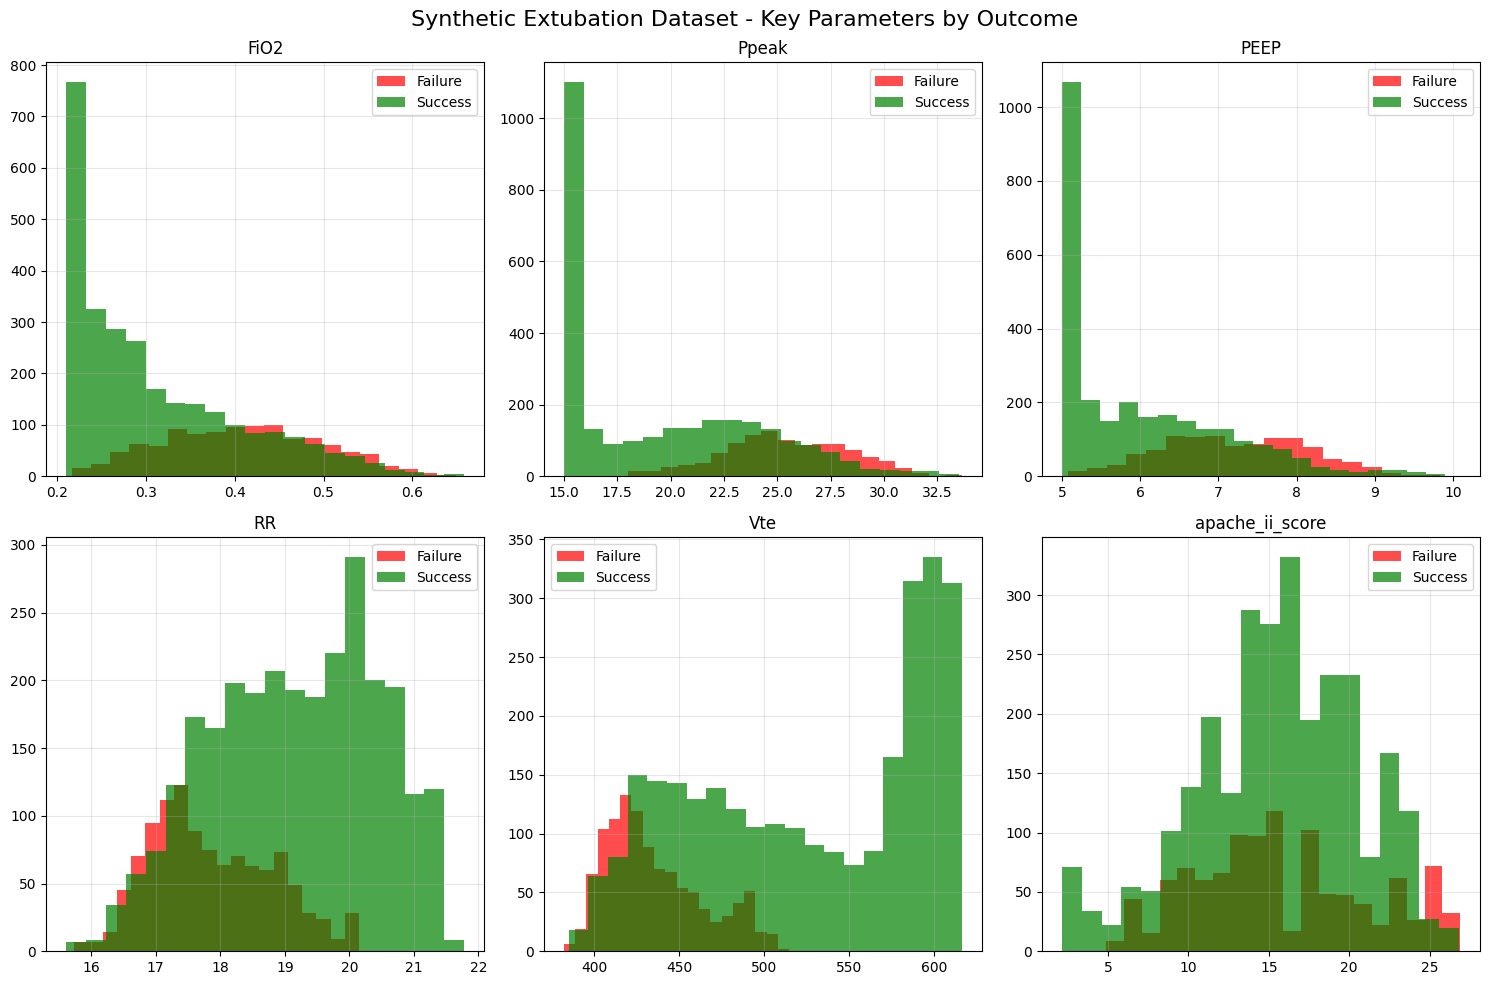


Correlation with Extubation Success:
Vte            :  0.562
Ppeak          : -0.541
Pmean          : -0.534
PEEP           : -0.475
FiO2           : -0.441
RR             :  0.441
apache_ii_score: -0.035

Datasets saved as:
- extubation_timeseries_data.csv
- extubation_prediction_windows.csv


In [ ]:
#This creates a clinical time series for 200 patients at once. Creates a window every 3 hours like real time patient monitoring.
'''1. Extubation Timeseries Data
Structure: This is a detailed, fine-grained dataset with one row per individual time point (every 3 minutes) per patient.
Content: Contains continuous readings of ventilator parameters (FiO2, Ppeak, PEEP, RR, Vte, etc.), patient characteristics, variability measures, and the extubation outcome label repeated for each time point of a patient.
Purpose: Useful for in-depth analysis of patient trajectories, for time-series models or detailed exploration of how features evolve over time.
Size & Detail: Large, with many rows per patient, representing the full timeline of ventilation monitoring.'''
'''2. Extubation Prediction Windows Data
Structure: Aggregated version, where data is summarized into fixed-length time windows (default 3 hours).
Content: Each row aggregates the mean values of the parameters over a window for a patient, along with patient characteristics and extubation outcome.
Purpose: Designed for supervised machine learning models that predict extubation success based on snapshot "decision points" rather than continuous time series.
Size & Detail: Smaller and more manageable; each row represents a relevant clinical decision moment, not every 3-minute reading.

'''

print("Generating synthetic extubation dataset...")
full_timeseries_data = generate_extubation_dataset(n_patients=200, avg_duration_hours=72)
prediction_windows_data = create_prediction_windows(full_timeseries_data)

# Display dataset information
print(f"\nFull Time Series Dataset:")
print(f"- Total records: {len(full_timeseries_data):,}")
print(f"- Unique patients: {full_timeseries_data['patient_id'].nunique()}")
print(f"- Average records per patient: {len(full_timeseries_data) / full_timeseries_data['patient_id'].nunique():.0f}")
print(f"- Extubation success rate: {full_timeseries_data.groupby('patient_id')['extubation_success'].first().mean():.1%}")

print(f"\nPrediction Windows Dataset:")
print(f"- Total prediction windows: {len(prediction_windows_data):,}")
print(f"- Unique patients: {prediction_windows_data['patient_id'].nunique()}")
print(f"- Average windows per patient: {len(prediction_windows_data) / prediction_windows_data['patient_id'].nunique():.0f}")
print(f"- Extubation success rate: {prediction_windows_data['extubation_success'].mean():.1%}")

# Save datasets
full_timeseries_data.to_csv('extubation_timeseries_data.csv', index=False)
prediction_windows_data.to_csv('extubation_prediction_windows.csv', index=False)

# Display sample data
print(f"\nSample from Time Series Data:")
print(full_timeseries_data.head(10)[['patient_id', 'hours_elapsed', 'FiO2', 'Ppeak', 'PEEP', 'RR', 'Vte', 'extubation_success']])

print(f"\nSample from Prediction Windows Data:")
print(prediction_windows_data.head()[['patient_id', 'window_start_hour', 'FiO2', 'Ppeak', 'PEEP', 'RR', 'Vte', 'extubation_success']])

# Basic statistics and visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Synthetic Extubation Dataset - Key Parameters by Outcome', fontsize=16)

parameters = ['FiO2', 'Ppeak', 'PEEP', 'RR', 'Vte', 'apache_ii_score']
for i, param in enumerate(parameters):
    row, col = i // 3, i % 3

    success_data = prediction_windows_data[prediction_windows_data['extubation_success'] == 1][param]
    failure_data = prediction_windows_data[prediction_windows_data['extubation_success'] == 0][param]

    axes[row, col].hist(failure_data, alpha=0.7, label='Failure', bins=20, color='red')
    axes[row, col].hist(success_data, alpha=0.7, label='Success', bins=20, color='green')
    axes[row, col].set_title(f'{param}')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation analysis
print(f"\nCorrelation with Extubation Success:")
feature_cols = ['FiO2', 'Ppeak', 'PEEP', 'Pmean', 'RR', 'Vte', 'apache_ii_score']
correlations = prediction_windows_data[feature_cols + ['extubation_success']].corr()['extubation_success'].sort_values(key=abs, ascending=False)
for feature, corr in correlations.items():
    if feature != 'extubation_success':
        print(f"{feature:15}: {corr:6.3f}")

print(f"\nDatasets saved as:")
print(f"- extubation_timeseries_data.csv")
print(f"- extubation_prediction_windows.csv")

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
feature_cols = ['FiO2', 'Ppeak', 'PEEP', 'Pmean', 'RR', 'Vte', 'apache_ii_score',
                'FiO2_variation', 'Ppeak_variation', 'PEEP_variation', 'Pmean_variation',
                'RR_variation', 'Vte_variation']

In [ ]:
X = prediction_windows_data[feature_cols]
y = prediction_windows_data['extubation_success']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
X_train

,FiO2,Ppeak,PEEP,Pmean,RR,Vte,apache_ii_score,FiO2_variation,Ppeak_variation,PEEP_variation,Pmean_variation,RR_variation,Vte_variation
864,0.264417,15.000000,5.000000,10.996667,20.201667,608.563333,14.819250,0.044767,0.000000,0.000000,0.080000,0.071667,1.050000
2210,0.326333,19.471667,5.703333,13.960000,18.886667,515.770000,15.510548,0.041800,0.053333,0.058333,0.100000,0.016667,0.930000
181,0.322450,25.726667,7.046667,18.246667,17.311667,428.051667,14.834660,0.047550,0.055000,0.041667,0.095000,0.061667,0.953333
2845,0.327183,16.648333,5.173333,12.060000,19.825000,564.081667,16.679429,0.051583,0.091667,0.075000,0.110000,0.058333,1.176667
3415,0.300633,15.508333,5.293333,11.438333,21.406667,598.120000,23.180647,0.053233,0.076667,0.056667,0.103333,0.073333,1.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3290,0.211717,15.321667,5.155000,11.256667,20.836667,582.868333,20.460433,0.000450,0.070000,0.023333,0.100000,0.035000,0.935000
987,0.348767,27.051667,7.553333,19.251667,17.261667,422.275000,14.774011,0.044050,0.041667,0.053333,0.100000,0.031667,0.876667
2468,0.318933,18.126667,5.211667,12.970000,17.521667,480.285000,6.779710,0.053467,0.055000,0.073333,0.101667,0.076667,1.086667
2040,0.419567,24.473333,7.666667,17.741667,19.025000,490.865000,17.444122,0.043133,0.040000,0.041667,0.093333,0.033333,0.856667


In [ ]:
y_train

,extubation_success
864,1
2210,1
181,0
2845,1
3415,1
...,...
3290,1
987,1
2468,0
2040,0


In [ ]:
model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)

In [ ]:
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:03:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [ ]:
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       221
           1       0.97      0.96      0.96       554

    accuracy                           0.95       775
   macro avg       0.94      0.94      0.94       775
weighted avg       0.95      0.95      0.95       775

ROC AUC: 0.985


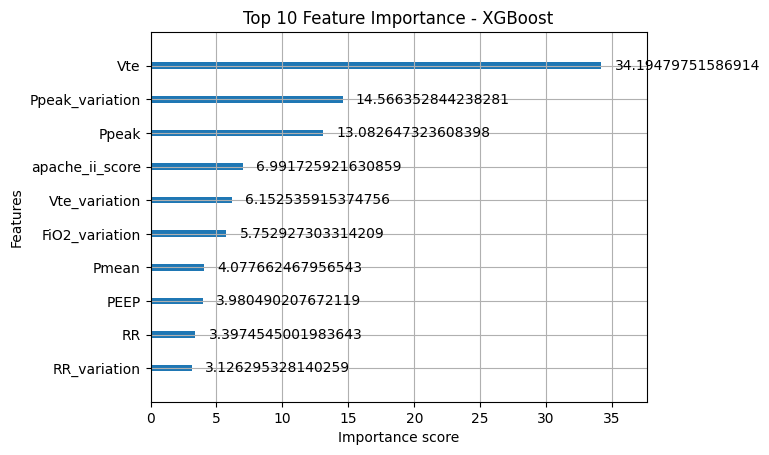

In [ ]:
xgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.title('Top 10 Feature Importance - XGBoost')
plt.show()

Implementing LSTM on the time series data:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from sklearn.model_selection import train_test_split

In [ ]:
feature_cols = [
    'FiO2', 'Ppeak', 'PEEP', 'Pmean', 'RR', 'Vte', 'apache_ii_score',
    'FiO2_variation', 'Ppeak_variation', 'PEEP_variation', 'Pmean_variation',
    'RR_variation', 'Vte_variation'
]
max_seq_len = 240

In [ ]:
X_seq = []
y_seq = []

In [ ]:

for patient_id, group in full_timeseries_data.groupby('patient_id'):
    arr = group[feature_cols].values  # Extract numerical values only

    if arr.shape[0] < max_seq_len:
        pad = np.zeros((max_seq_len - arr.shape, len(feature_cols)))
        arr = np.vstack([arr, pad])
    else:
        arr = arr[:max_seq_len, :]

    X_seq.append(arr)
    y = int(group['extubation_success'].iloc[0])
    y_seq.append(y)

In [ ]:
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42
)


In [ ]:

model = Sequential([
    Masking(mask_value=0., input_shape=(max_seq_len, len(feature_cols))),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=32
)

Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 252ms/step - accuracy: 0.7421 - loss: 0.6095 - val_accuracy: 0.7250 - val_loss: 0.5960
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.7373 - loss: 0.5859 - val_accuracy: 0.7250 - val_loss: 0.5885
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.7065 - loss: 0.6049 - val_accuracy: 0.7250 - val_loss: 0.5879
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.7252 - loss: 0.5878 - val_accuracy: 0.7250 - val_loss: 0.5876
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.7191 - loss: 0.5945 - val_accuracy: 0.7250 - val_loss: 0.5861
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.7065 - loss: 0.6056 - val_accuracy: 0.7250 - val_loss: 0.5853
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.7182 - loss: 0.5925 - val_accuracy: 0.7250 - val_loss: 0.5843
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.7460 - loss: 0.5647 - val_accuracy: 0.7250 - val_loss:

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7125 - loss: 0.5581
Test Loss: 0.5498, Test Accuracy: 0.7250
